In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from mnist_generator import *
import mnist

In [2]:
# Lecture de "l'email"
with open("email.json", "r") as fp:
    email = json.load(fp)

In [3]:
expected_notes = [19, 20, 8, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 16,16,17,18,]

In [4]:
# On récupère la transformation à appliquer aux images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# On charge le modèle sauvegardé
mnist_model = mnist.Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_dict = torch.load("mnist_cnn.pt", map_location=device)
mnist_model.load_state_dict(mnist_dict)

<All keys matched successfully>

In [6]:
generator = Generator()
generator.load_state_dict(torch.load("mnist_generator100.pt"))
generator.eval()

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [7]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100))
    label = torch.LongTensor([digit])
    img = generator(z, label)
    img = (0.5 * img + 0.5).detach().numpy()
    img = np.round_(img, decimals=3)
    img = img * 255 
    img = np.round_(img, decimals=0)
    return torch.from_numpy(img)

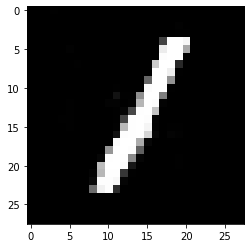

In [8]:
image = generate_digit(generator, 1)
#print(image)

#transforms.ToPILImage()(image)
plt.imshow(np.array(image).reshape(28, -1), cmap='gray',interpolation='none')

In [9]:
def compute_number(img, mnist_model):
    img = np.array(img).reshape(28, 28).astype("uint8")
    img_tensor = transform(img)
    batched_img_tensor = img_tensor.reshape(1, 1, 28, 28)
    prediction = mnist_model(batched_img_tensor)
    number = prediction.data.max(1, keepdim=True)[1][0].numpy()[0]
    return number

In [10]:
def number_to_pair(num):
    return (num//10, num%10)

In [11]:
def distance_image(image_base, image_modifiee):
    return np.linalg.norm(np.array(image_base) - np.array(image_modifiee))


In [12]:
def modify_notes2(generator, email,expected_notes, mnist_smodel):
    notes = list(map(number_to_pair, expected_notes))
    existed_image = []
    for i in range(len(email)):
        
        note1 = email[i]["note_dizaine"]
        note2 = email[i]["note_unite"]
        
        note1 = compute_number(note1, mnist_model)
        note2 = compute_number(note2, mnist_model)
        
        if((note1, note2) in notes):
            notes.remove((note1,note2))
            existed_image.append(i)
            
    for i in range(len(email)):
        
        note1 = email[i]["note_dizaine"]
        note2 = email[i]["note_unite"]
        
        note1 = compute_number(note1, mnist_model)
        note2 = compute_number(note2, mnist_model)
        
        if(i not in existed_image):
            found = False
            
            for note in notes:
                a, b = note[0], note[1]
                if(a == note1):
                    img = generate_digit(generator, b).view(784).tolist()
                    while(compute_number(img, mnist_model) != b):
                        img = generate_digit(generator, b).view(784).tolist()
                        print(note2, compute_number(img, mnist_model))
                        
                    email[i]["note_unite"] = img
                    notes.remove((a, b))
                    found = True
                    break
                elif (b == note2):
                    img = generate_digit(generator, a).view(784).tolist()
                    while(compute_number(img, mnist_model) != a):
                        img = generate_digit(generator, a).view(784).tolist()
                        print(note1, compute_number(img, mnist_model))
                    
                    email[i]["note_dizaine"] = img
                    
                    notes.remove((a, b))
                    found = True
                    break
        
            if(not found):
                note = notes.pop()
                a, b = note[0], note[1]
                
                img1 = generate_digit(generator, a).view(784).tolist()
                img2 = generate_digit(generator, b).view(784).tolist()
        
                while (compute_number(img1, mnist_model) != a):
                    img1 = generate_digit(generator, a).view(784).tolist()
                    
                while(compute_number(img2, mnist_model) != b):
                    img2 = generate_digit(generator, b).view(784).tolist()
                email[i]["note_dizaine"] = img1
                email[i]["note_unite"] = img2
        print(".......")
    with open('modified.json', 'w') as outfile:
        json.dump(email, outfile)

In [15]:
def modify_notess(generator, email,expected_notes, mnist_smodel):
    notes = list(map(number_to_pair, expected_notes))
    existed_image = []
    for i in range(len(email)):
        
        note1 = email[i]["note_dizaine"]
        note2 = email[i]["note_unite"]
        
        note1 = compute_number(note1, mnist_model)
        note2 = compute_number(note2, mnist_model)
        
        if((note1, note2) in notes):
            notes.remove((note1,note2))
            existed_image.append(i)
        
    for i in range(len(email)):
        
        img1_base = email[i]["note_dizaine"]
        img2_base = email[i]["note_unite"]
        
        note1 = compute_number(img1_base, mnist_model)
        note2 = compute_number(img2_base, mnist_model)
        
        dist1, dist2 = 0, 0
        if(i not in existed_image):
            found = False
            
            for note in notes:
                a, b = note[0], note[1]
                if(a == note1):
                    img = generate_digit(generator, b).view(784).tolist()
                    dist2 = distance_image(img2_base ,img)
                    while (dist2 > 3000) or (compute_number(img, mnist_model) != b):
                        img = generate_digit(generator, b).view(784).tolist()
                        dist2 = distance_image(img2_base ,img)
                    
                    email[i]["note_unite"] = img
                    notes.remove((a, b))
                    found = True
                    break
                elif (b == note2):
                    img = generate_digit(generator, a).view(784).tolist()
                    dist1 = distance_image(img1_base ,img)
                    while (dist1 > 3000) or (compute_number(img, mnist_model) != a):
                        img = generate_digit(generator, a).view(784).tolist()
                        dist1 = distance_image(img1_base ,img)
                    
                    email[i]["note_dizaine"] = img
                    
                    notes.remove((a, b))
                    found = True
                    break
        
            if(not found):
                note = notes.pop()
                a, b = note[0], note[1]
                
                img1 = generate_digit(generator, a).view(784).tolist()
                img2 = generate_digit(generator, b).view(784).tolist()
                
                dist1 = distance_image(img1_base ,img1)
                dist2 = distance_image(img2_base ,img2)
                    
                while (dist1 > 3000) or (compute_number(img1, mnist_model) != a):
                    img1 = generate_digit(generator, a).view(784).tolist()
                    dist1 = distance_image(img1_base ,img1)
                    
                while (dist2 > 3000) or (compute_number(img2, mnist_model) != b):
                    img2 = generate_digit(generator, b).view(784).tolist()
                    dist2 = distance_image(img2_base ,img2)
                    
                email[i]["note_dizaine"] = img1
                email[i]["note_unite"] = img2
        print(dist1, dist2)
        
    with open('modified.json', 'w') as outfile:
        json.dump(email, outfile)

In [16]:
modify_notes2(generator, email, expected_notes, mnist_model)

0 0
0 0
2992.4929406767196 0
0 0
2768.5033863082053 0
2821.8265361286826 0
2951.3944162039747 0
2966.6457489899262 0
2789.620045812691 0
2890.2712675456605 0
2969.701836885313 0
2648.327207880476 2921.9750170047655
2157.270961191477 2956.276204957852
2670.5520028638275 0
2878.755633950197 2671.572570603314
2676.3811387767623 2589.4161504092
2978.5848989075334 0
0 0
2516.9926499694034 2193.809472128334
2988.6532083866805 0


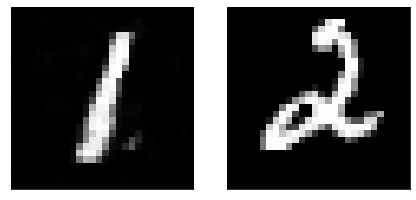

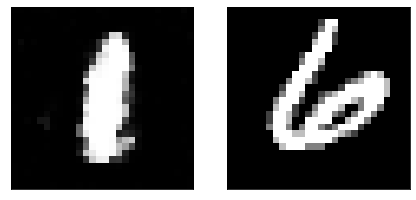

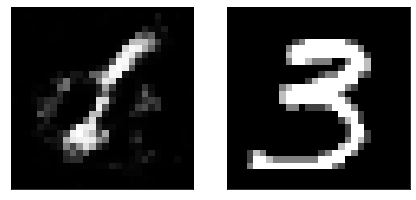

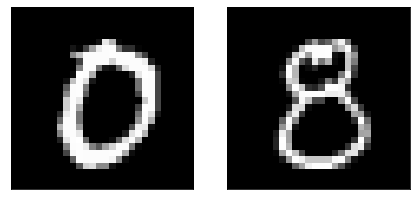

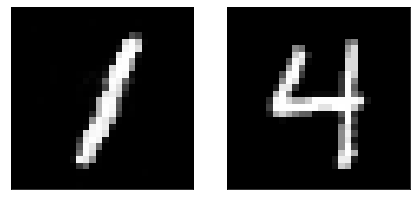

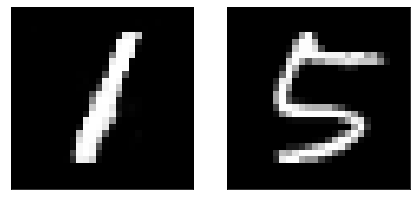

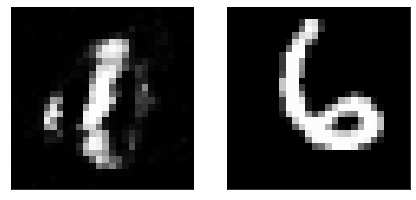

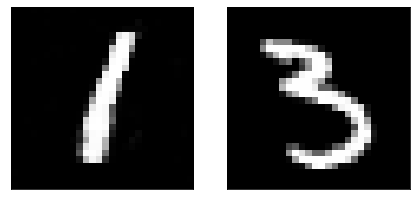

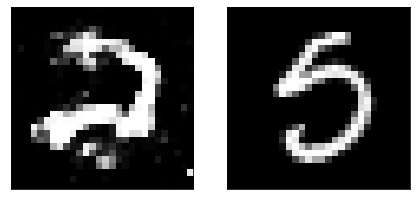

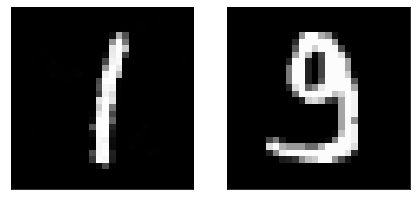

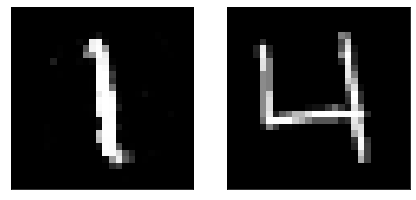

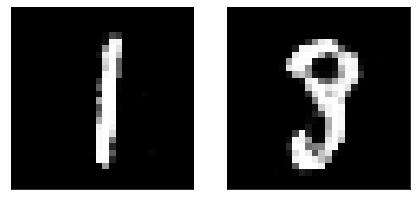

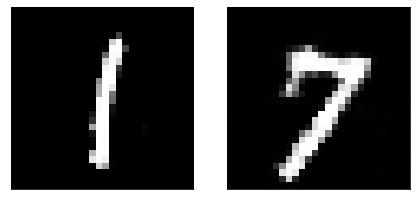

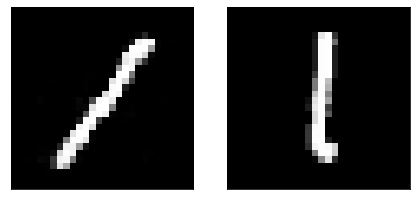

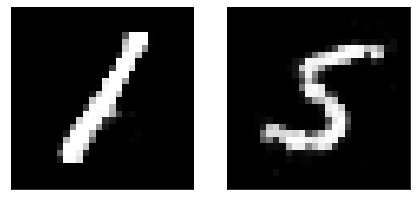

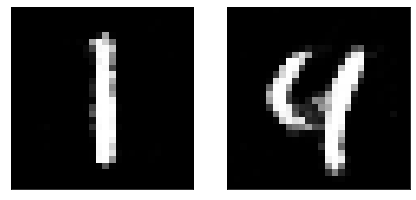

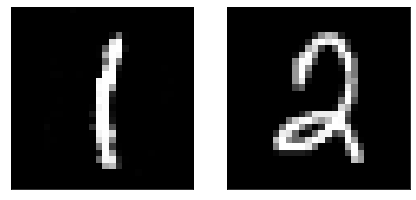

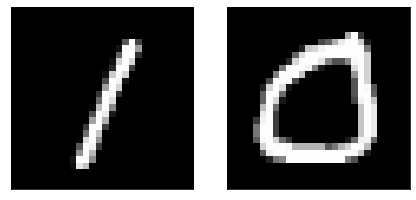

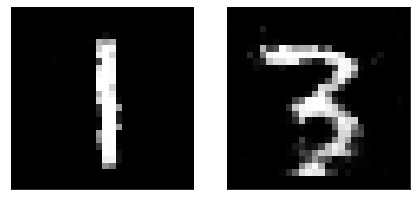

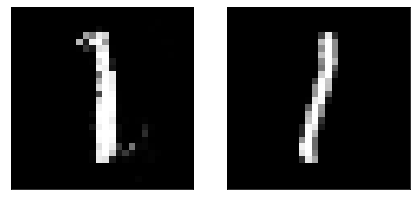

In [18]:
for i in range(len(email)):
    student = email[i]
    # Sa note 
    fig = plt.figure()
    for position, key in enumerate(["note_dizaine", "note_unite"], 1):
        plt.subplot(1, 2, position)
        plt.tight_layout()
        plt.imshow(
            np.array(student[key]).reshape(28, -1),
            cmap='gray',
            interpolation='none'
        )
        plt.xticks([])
        plt.yticks([])
    
fig;

In [19]:
for i in range(len(email)):
    student = email[i]
    img1 = student["note_dizaine"]
    img2 = student["note_unite"]
    
    img1 = np.array(img1).reshape(28, 28).astype("uint8")
    img2 = np.array(img2).reshape(28, 28).astype("uint8")
   
    # On applique la transformation utilisée par le modèle fitté
    img1_tensor = transform(img1)
    img2_tensor = transform(img2)
    #print(img1_tensor)
    #break
    # On simule un batch (de taille 1)
    batched_img1_tensor = img1_tensor.reshape(1, 1, 28, 28)
    batched_img2_tensor = img2_tensor.reshape(1, 1, 28, 28)
    # On génère la prédiction
    prediction1 = mnist_model(batched_img1_tensor)
    prediction2 = mnist_model(batched_img2_tensor)
    # On garde la classe la plus probable
    number1 = prediction1.data.max(1, keepdim=True)[1][0].numpy()[0]
    number2 = prediction2.data.max(1, keepdim=True)[1][0].numpy()[0]
    print(number1, number2)

1 2
1 6
1 3
0 8
1 4
1 5
1 6
1 3
2 0
1 9
1 4
1 8
1 7
1 1
1 5
1 4
1 2
1 0
1 3
1 1
